In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
ls *load*

biomag_download_info.ipynb  download_output.txt


In [18]:
ls /mnt/hcp-meg/105923/

rest-run0-preproc-raw.fif  rest-run1-preproc-raw.fif  rest-run2-preproc-raw.fif


In [538]:
import os.path as op
import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression

In [44]:
sns.set_style('ticks')

In [20]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

In [23]:
recordings_path = '/mnt/hcp-meg'
subject = '105923'

In [24]:
fname = op.join(recordings_path, subject, 'rest-run0-preproc-raw.fif')

In [96]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.


<ipython-input-96-826c3e305aa6>:1: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


In [97]:
raw.load_data()

Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [98]:
def _preprocess_raw(raw, hcp_params, ica_sel):
    # construct MNE annotations
    annots = hcp.read_annot(**hcp_params)
    bad_seg = (annots['segments']['all']) / raw.info['sfreq']
    annotations = mne.Annotations(
        bad_seg[:, 0], (bad_seg[:, 1] - bad_seg[:, 0]),
        description='bad')

    raw.annotations = annotations
    raw.info['bads'] += annots['channels']['all']
    raw.pick_types(meg=True, ref_meg=False)

    # read ICA and remove EOG ECG or keep brain components
    ica_mat = hcp.read_ica(**hcp_params)
    if ica_sel == 'ecg_eog':
        exclude = annots['ica']['ecg_eog_ic']
    elif ica_sel == 'brain':
        exclude = [ii for ii in range(annots['ica']['total_ic_number'][0])
                   if ii not in annots['ica']['brain_ic_vs']]

    preproc.apply_ica_hcp(raw, ica_mat=ica_mat, exclude=exclude)
    # add back missing channels
    raw = preproc.interpolate_missing(raw, **hcp_params)
    return raw

In [99]:
hcp_params = dict(subject=subject, hcp_path=op.join('/mnt', 'HCP'),
                  data_type='rest')

raw = _preprocess_raw(raw, hcp_params=hcp_params, ica_sel='ecg_eog')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Creating RawArray with float64 data, n_channels=248, n_times=749070
Current compensation grade : 0
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 84 missing 0.0001]


In [622]:
1/2048. * (2 ** 18)

128.0

In [623]:
freqs, psd = welch(raw[100][0], nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear')

## works with with natural log

6.24416690066


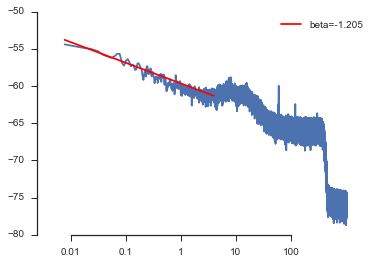

In [624]:
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log(freqs[fmask][:, None]),
   np.log(psd.T[fmask]),
   )
frange = np.log(freqs[fmask].max()) - np.log(freqs[fmask].min())
print(frange)
plt.figure()
plt.plot(np.log(freqs), np.log(psd.T))
plt.plot(np.log(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log([0.01, 0.1, 1, 10, 100]),
                  [0.01, 0.1, 1, 10, 100])
sns.despine(trim=True)

## works with with decadic log

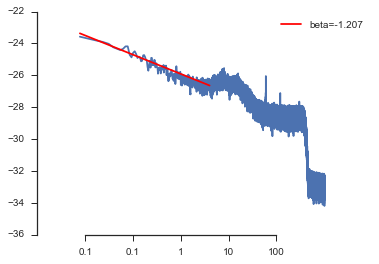

In [567]:
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)

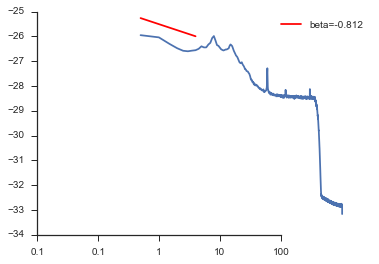

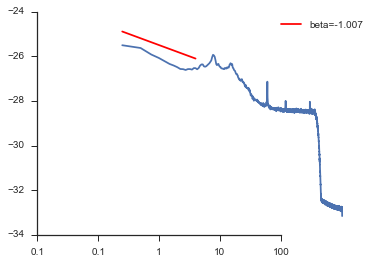

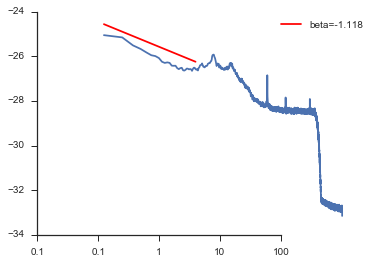

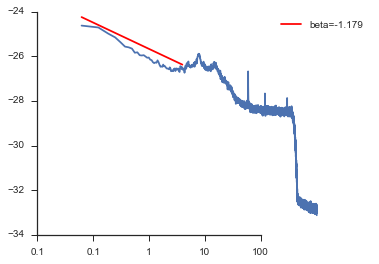

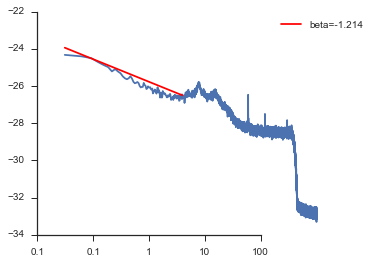

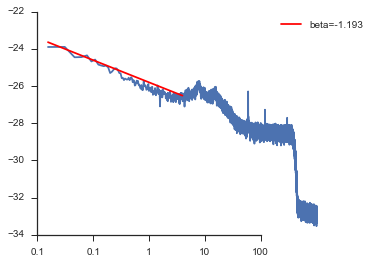

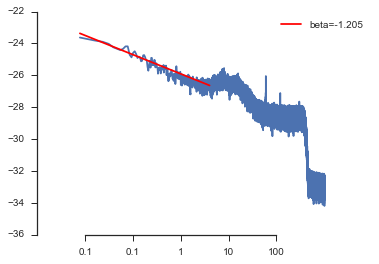

In [625]:
for exp in [12, 13, 14, 15, 16, 17, 18]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='linear')
    fmask = (freqs <= 4) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    plt.figure()
    plt.plot(np.log10(freqs), np.log10(psd.T))
    plt.plot(np.log10(freqs[fmask][[0, -1]]),
             np.array([lm.intercept_,
                       lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
             label='beta=%0.3f' % lm.coef_[0])
    plt.legend(loc='best')
    plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
    sns.despine(trim=True)  